In [1]:

from DescritoresDeImagem.readwritendarray import extractimagesdescriptor, readfilendarray
from DescritoresDeImagem.utils import lpq_function

# Standart Scale, SVC and KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from scipy.stats import loguniform

import numpy as np
import pickle


In [2]:
#GLCM

distances=[1,2,4,8,16,32,64,128,256]
angles=np.deg2rad([0,45,90,180,270])


#LBP
Winsize=25

decorr=1

CVPARTS=5 # number of CV parts
RUN=False

if RUN:
    function_glcm=extractimagesdescriptor("DadosExtraidos/Y_Resultado.txt","DadosExtraidos/X_GLCM.txt","BasedeDados/*.bmp","GLCM",)
    function_glcm(angles=angles,distances=distances)

    function_lbp=extractimagesdescriptor(file="DadosExtraidos/Y_Resultado.txt",filename="DadosExtraidos/X_LBP.txt",pathimg="BasedeDados/*.bmp",descriptor="LBP")
    function_lbp(winSize=Winsize,decorr=decorr)



X_lbp=readfilendarray(filename="DadosExtraidos/X_LBP.txt")

X_lpq=lpq_function("BasedeDados/*.bmp",P=25,R=6)

X_glcm=readfilendarray(filename="DadosExtraidos/X_GLCM.txt")

y=readfilendarray(filename="DadosExtraidos/Y_Resultado.txt",data="s")

y = y.reshape(-1, 1)

x_lpq_lpq_glcm=np.concatenate((X_lbp,X_lpq,X_glcm,y),axis=1)


knn_x_lpq_lpq_glcm=np.concatenate((X_lbp,X_lpq,y),axis=1)

X_train_model,X_test_model=train_test_split(x_lpq_lpq_glcm,test_size=0.2,train_size=0.8,random_state=999)

X_train_knn_model,X_test_knn_model=train_test_split(knn_x_lpq_lpq_glcm,test_size=0.2,train_size=0.8,random_state=999)
print(X_train_knn_model.shape)

(3360, 860)


In [3]:
y_train=X_train_model[:,-1]
y_test=X_test_model[:,-1]


X_train_model=X_train_model[:,:-1]
X_test_model=X_test_model[:,:-1]



In [4]:
y_test_knn=X_test_knn_model[:,-1]
y_train_knn=X_train_knn_model[:,-1]

X_test_knn_model=X_test_knn_model[:,:-1]
X_train_knn_model=X_train_knn_model[:,:-1]


In [5]:
def randomgridsearchotimizator(n_iter:int,scoring:str,cvparts,pipe,parameters):
    return RandomizedSearchCV(estimator=pipe,param_distributions=parameters,n_iter=n_iter,scoring=scoring,cv=cvparts,n_jobs=6,error_score='raise')

In [6]:
pipe=Pipeline(steps=[("scalar",StandardScaler()),
                     ('pca', PCA()),
                     ("model",SVC())])


parameters = {
    "pca__n_components":[16,32,64,128,256,280,300,1024,2048],
    "pca__svd_solver":['auto', 'full', 'arpack', 'randomized'],
    "model__coef0": [0,1,2,3,4,5,10,15,20],
    "model__degree": [1,2,3,4,5,10,15,18,20],
    "model__kernel": ['poly',"rbf","sigmoid"],
    "model__C": loguniform(1e-5, 1e3),
    "model__gamma": ["scale", "auto"],
    "model__tol": loguniform(1e-5, 1e-1),
}



In [7]:

NOTOPTPARAMATERS=True
svmlbp_lpq=None

if NOTOPTPARAMATERS:
    with open("./Models/svm_LBP_LPQ_GLCM.pkl",mode="rb") as f:
        svmlbp_lpq=pickle.load(f)
else:
    svmlbp_lpq=randomgridsearchotimizator(parameters=parameters,pipe=pipe,scoring="f1_macro",cvparts=5,n_iter=30)

/home/guilherme/teste/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/guilherme/teste/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/guilherme/teste/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.6.0. This might lead to breaki

In [8]:
if not NOTOPTPARAMATERS:
    svmlbp_lpq.fit(X=X_train_model,y=y_train)

In [9]:
print(svmlbp_lpq.best_score_)
print(svmlbp_lpq.best_params_)


0.7664628965097929
{'model__C': np.float64(0.1554544978843174), 'model__coef0': 10, 'model__degree': 10, 'model__gamma': 'scale', 'model__kernel': 'poly', 'model__tol': np.float64(0.0002537045643644857), 'pca__n_components': 1024, 'pca__svd_solver': 'arpack'}


In [10]:
ln=LabelEncoder()
ln_y_teste_svm=ln.fit_transform(y_test)

In [11]:
ypredsvmglcm=svmlbp_lpq.predict(X=X_test_model)

In [12]:
print("\tSVM (LBP+LPQ+GLCM) \n")
print(classification_report(ln_y_teste_svm,y_pred=ypredsvmglcm)+"\n")

	SVM (LBP+LPQ+GLCM) 

              precision    recall  f1-score   support

           0       0.80      0.81      0.80        73
           1       0.88      0.86      0.87        66
           2       0.68      0.80      0.73        64
           3       0.77      0.76      0.77        76
           4       0.72      0.68      0.70        74
           5       0.77      0.70      0.73        76
           6       0.78      0.80      0.79        66
           7       0.85      0.74      0.79        72
           8       0.86      0.75      0.80        72
           9       0.84      0.85      0.85        87
          10       0.66      0.73      0.69        51
          11       0.66      0.79      0.72        63

    accuracy                           0.77       840
   macro avg       0.77      0.77      0.77       840
weighted avg       0.78      0.77      0.77       840




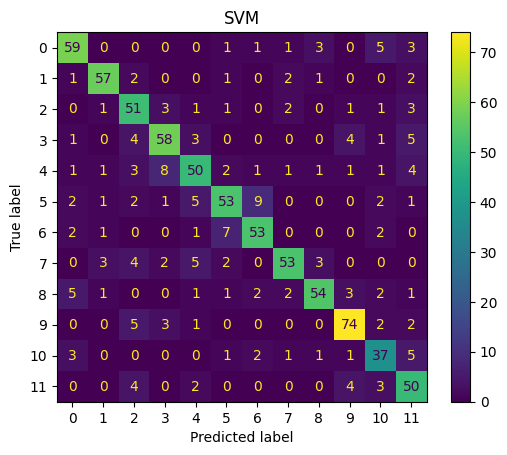

In [13]:
ConfusionMatrixDisplay.from_predictions(ln_y_teste_svm,y_pred=ypredsvmglcm)
plt.title("SVM")
plt.show()

In [14]:

stand=StandardScaler()
ipc=PCA(n_components=1)
max_scaler=MinMaxScaler()

ipc_train=ipc.fit_transform(X_train_knn_model)
ipc_train=max_scaler.fit_transform(ipc_train)
trains=stand.fit_transform()

plt.scatter(trains,y_train_knn)

TypeError: TransformerMixin.fit_transform() missing 1 required positional argument: 'X'

In [ ]:
pipe_knn=Pipeline(steps=[("scalar",StandardScaler()),
                     ('pca', PCA()),
                     ("maxmin",MinMaxScaler()),
                     ("knn",KNeighborsClassifier())]) 
parameters_knn = {
    "pca__n_components":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,20,32],
    "pca__svd_solver":['auto', 'full', 'randomized'],
    "knn__n_neighbors": [1,2,3,5,7,10,15,20,25,30],  
    "knn__weights": ['uniform', 'distance'],
    "knn__metric": ['euclidean', 'manhattan','chebyshev'], 
    "knn__algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
    "knn__leaf_size": [1,2,3,4,5,10,20, 30,50],  
    "knn__p": [1, 2]  
}



In [ ]:

NOTOPTPARAMATERS=False

if NOTOPTPARAMATERS:
   knn_lbp_lqb_glcm=svmlbp_lpq=pickle.load("./Models/knn_LBP_LPQ_GLCM.pkl")
else:
    knn_lbp_lqb_glcm=randomgridsearchotimizator(parameters=parameters_knn,pipe=pipe_knn,scoring="f1_macro",cvparts=CVPARTS,n_iter=29)

In [ ]:
labelencoder=LabelEncoder()

ln_y=labelencoder.fit_transform(y_train_knn)

In [ ]:
knn_lbp_lqb_glcm.fit(X=X_train_knn_model,y=ln_y)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                             ('pca', PCA()),
                                             ('maxmin', MinMaxScaler()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=29, n_jobs=6,
                   param_distributions={'knn__algorithm': ['auto', 'ball_tree',
                                                           'kd_tree', 'brute'],
                                        'knn__leaf_size': [1, 2, 3, 4, 5, 10,
                                                           20, 30, 50],
                                        'knn__metric': ['euclidean',
                                                        'manhattan',
                                                        'chebyshev'],
                                        'knn__n_neighbors': [1, 2, 3, 5, 7, 10,
                                                             15, 20, 25, 30],
                                        'knn__p': [1, 2],
                                        'knn__weights': ['uniform', 'distance'],
                                        'pca__n_components': [16, 20, 32, 35,
                                                              36, 40, 41, 42,
                                                              43, 64, 128],
                                        'pca__svd_solver': ['auto', 'full',
                                                            'randomized']},
                   scoring='f1_macro')

In [ ]:

ln_y_test=labelencoder.fit_transform(y_test_knn)

print(knn_lbp_lqb_glcm.best_params_)
print(knn_lbp_lqb_glcm.best_score_)

{'pca__svd_solver': 'auto', 'pca__n_components': 32, 'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 30, 'knn__metric': 'euclidean', 'knn__leaf_size': 1, 'knn__algorithm': 'auto'}
0.5223749408608505


In [ ]:
ypredknnglcm=knn_lbp_lqb_glcm.predict(X=X_test_knn_model)

In [ ]:
print("\tKNN(LBP+LPQ+GLCM) \n")
print(classification_report(y_true=ln_y_test,y_pred=ypredknnglcm)+"\n")

	KNN(LBP+LPQ+GLCM) 

              precision    recall  f1-score   support

           0       0.92      0.30      0.45        73
           1       0.70      0.67      0.68        66
           2       0.28      0.70      0.40        64
           3       0.72      0.47      0.57        76
           4       0.38      0.41      0.39        74
           5       0.44      0.34      0.39        76
           6       0.50      0.48      0.49        66
           7       0.85      0.49      0.62        72
           8       0.88      0.29      0.44        72
           9       0.62      0.62      0.62        87
          10       0.41      0.63      0.49        51
          11       0.37      0.65      0.47        63

    accuracy                           0.50       840
   macro avg       0.59      0.50      0.50       840
weighted avg       0.60      0.50      0.50       840




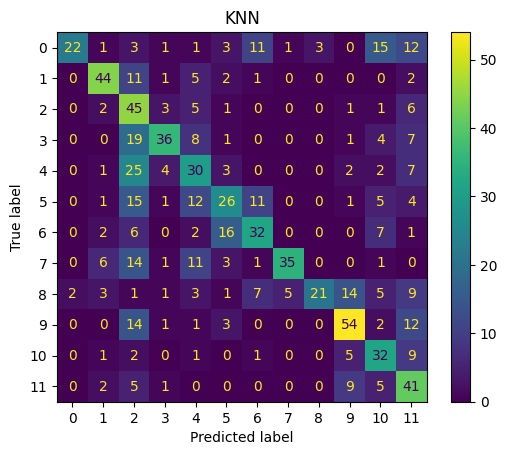

In [ ]:
ConfusionMatrixDisplay.from_predictions(ln_y_test,y_pred=ypredknnglcm)
plt.title("KNN")
plt.show()

In [ ]:
with open(f"Models/svm_LBP_LPQ_GLCM.pkl",mode="wb") as fsvm:
    pickle.dump(svmlbp_lpq,fsvm)


In [ ]:

with open("Models/knn_LBP_LPQ_GLCM.pkl",mode="wb") as fknn:
    pickle.dump(knn_lbp_lqb_glcm,fknn)